In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

In [2]:
import sys
sys.path.append("../")
import albumentations as A
from albumentations.pytorch.transforms import ToTensorV2
from sklearn.model_selection import StratifiedKFold


In [29]:
        df = pd.read_csv("../data/merged.csv")
        df_20 = df.loc[df["source"] == 2020]
        df_20["data_dir"] = "train_images"
        df_19_0 = df.loc[(df["source"] == 2019) & (df["label"] == 0)]
        df_19_0["data_dir"] = "train/cbb/"
        df_19_2 = df.loc[(df["source"] == 2019) & (df["label"] == 2)]
        df_19_0["data_dir"] = "train/cgm/"
        df_19_4 = df.loc[(df["source"] == 2019) & (df["label"] == 4)]
        df_19_0["data_dir"] = "train/healthy/"

        df = pd.concat([df_20, df_19_0, df_19_2, df_19_4], axis=0).reset_index(drop=True)

In [30]:
df["label"].value_counts()

3    13158
2     3017
4     2890
1     2189
0     1492
Name: label, dtype: int64

In [31]:
df_19_0.sample(frac=1.6, replace=True).shape

# if config.upsampling:
df_0 = df.loc[df["label"] == 0].sample(frac=3, replace=True)
df_1 = df.loc[df["label"] == 1].sample(frac=2, replace=True)
df_2 = df.loc[df["label"] == 2].sample(frac=2, replace=True)
df_4 = df.loc[df["label"] == 4].sample(frac=2, replace=True)

df = pd.concat([df_0, df_1, df_2, df_4, df.loc[df["label"] == 3]], axis=0).reset_index(drop=True)

In [32]:
df.label.value_counts()

3    13158
2     6034
4     5780
0     4476
1     4378
Name: label, dtype: int64

In [36]:
import numpy as np
import sys
import torch
sys.path.append("../libs/FMix")

from fmix import sample_mask


def rand_bbox(size, lam):
    W = size[2]
    H = size[3]
    cut_rat = np.sqrt(1. - lam)
    cut_w = np.int(W * cut_rat)
    cut_h = np.int(H * cut_rat)

    # uniform
    cx = np.random.randint(W)
    cy = np.random.randint(H)

    bbx1 = np.clip(cx - cut_w // 2, 0, W)
    bby1 = np.clip(cy - cut_h // 2, 0, H)
    bbx2 = np.clip(cx + cut_w // 2, 0, W)
    bby2 = np.clip(cy + cut_h // 2, 0, H)
    return bbx1, bby1, bbx2, bby2

def cutmix(data, target, alpha):
    indices = torch.randperm(data.size(0))
    shuffled_data = data[indices]
    shuffled_target = target[indices]

    lam = np.clip(np.random.beta(alpha, alpha),0.3,0.4)
    bbx1, bby1, bbx2, bby2 = rand_bbox(data.size(), lam)
    new_data = data.clone()
    new_data[:, :, bby1:bby2, bbx1:bbx2] = data[indices, :, bby1:bby2, bbx1:bbx2]
    # adjust lambda to exactly match pixel ratio
    lam = 1 - ((bbx2 - bbx1) * (bby2 - bby1) / (data.size()[-1] * data.size()[-2]))
    targets = (target, shuffled_target, lam)

    return new_data, targets

def fmix(data, targets, alpha, decay_power, shape, device, max_soft=0.0, reformulate=False):
    data = data.detach().cpu()
    lam, mask = sample_mask(alpha, decay_power, shape, max_soft, reformulate)
    indices = torch.randperm(data.size(0))
    shuffled_data = data[indices]
    shuffled_targets = targets[indices]
    x1 = torch.from_numpy(mask)*data
    x2 = torch.from_numpy(1-mask)*shuffled_data
    # x1 = x1.to(device)
    # x2 = x2.to(device)
    targets=(targets, shuffled_targets, lam)
    
    return (x1+x2), targets

def mix_criterion(preds, targets, criterion):
    targets1, targets2, lam = targets[0], targets[1], targets[2]
    return lam * criterion(preds, targets1) + (1 - lam) * criterion( preds, targets2)

In [37]:
DATA_DIR = "../data"
label2idx = {"cgm": 2, "cbb": 0, "cbsd": 1, "cmd": 3, "healthy": 4}

def onehot(size, target):
    vec = torch.zeros(size, dtype=torch.float32)
    vec[target] = 1.
    return vec

class KaggleDataset(Dataset):
    def __init__(self, df, transforms=None, mode="train"):
        self.df = df.reset_index(drop=True)
        self.transforms = transforms
        self.mode=mode


    def __getitem__(self, idx):
        data_dir = self.df.loc[idx, "data_dir"]
        image = os.path.join(DATA_DIR, data_dir, self.df.loc[idx, "image_id"])
        image = cv2.imread(image)
        image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)

        label = self.df.loc[idx, "label"]
        label = onehot(5, label)

        if self.transforms:
            augmented = self.transforms(image=image)
            image = augmented['image']

        return torch.tensor(image, dtype=torch.float), label

    def __len__(self):
        return self.df.shape[0]

    def get_labels(self):
        return list(self.df.label.values)

In [16]:
img_size = (512, 512)


train_transforms = A.Compose([
            # A.RandomResizedCrop(600, 800),
            A.Transpose(p=0.5),
            A.HorizontalFlip(p=0.5),
            A.VerticalFlip(p=0.5),
            A.ShiftScaleRotate(p=0.5),
            A.HueSaturationValue(
                hue_shift_limit=0.2, 
                sat_shift_limit=0.2, 
                val_shift_limit=0.2, 
                p=0.5
            ),
            A.RandomBrightnessContrast(
                brightness_limit=(-0.1,0.1), 
                contrast_limit=(-0.1, 0.1), 
                p=0.5
            ),
            A.Resize(img_size[0], img_size[1], p=1.0),
            A.Normalize(
                mean=[0.485, 0.456, 0.406], 
                std=[0.229, 0.224, 0.225], 
                max_pixel_value=255.0, 
                p=1.0
            ),
            A.CoarseDropout(p=0.5),
            A.Cutout(num_holes=8, max_h_size=64, max_w_size=64, fill_value=0, p=0.7),
            ToTensorV2(p=1.0),
        ], p=1.0)


valid_transforms = A.Compose([
            A.Resize(img_size[0], img_size[1], p=1.0),
            A.Normalize(),
            ToTensorV2(p=1.0),
        ], p=1.0)


In [40]:
    df = pd.read_csv("../data/train.csv")
    train_dataset = KaggleDataset(
        df=df,
        transforms=train_transforms,
        mode="train"
    )

    train_loader = torch.utils.data.DataLoader(
        train_dataset,
        # sampler=BalanceClassSampler(labels=train_dataset.get_labels(), mode="downsampling"),
        batch_size=32,
        pin_memory=True,
        num_workers=4,
    )


In [28]:
img, la = train_dataset[3]

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


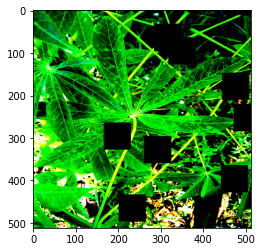

In [29]:
plt.imshow(img.permute(1, 2, 0))

In [41]:
it = iter(train_loader)


In [42]:
images, targets = it.next()

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


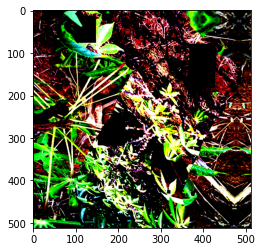

In [54]:
aug_images, aug_targets = fmix(images, targets, alpha=1., decay_power=2., shape=(512, 512), device=torch.device("cpu"))
img = aug_images[1]
plt.imshow(img.permute(1, 2, 0))

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


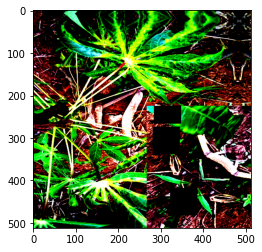

In [55]:
aug_images, aug_targets = cutmix(images, targets, 1.)
img = aug_images[1]
plt.imshow(img.permute(1, 2, 0))

In [5]:
import pandas as pd
df = pd.read_csv("../data/train.csv")


In [6]:
df["kfold"] = -1
df = df.sample(frac=1).reset_index(drop=True)
y = df["label"].values
skf = StratifiedKFold(n_splits=5)

for (fold_num), (train_index, val_index) in enumerate(skf.split(X=df, y=y)):
    df.loc[df.iloc[val_index].index, "kfold"] = fold_num

In [8]:
for fn in range(5):
    tmp_df = df.loc[df["kfold"] != fn]
    print(tmp_df["label"].value_counts())

3    10526
4     2062
2     1909
1     1751
0      869
Name: label, dtype: int64
3    10526
4     2062
2     1908
1     1751
0      870
Name: label, dtype: int64
3    10526
4     2061
2     1909
1     1752
0      870
Name: label, dtype: int64
3    10527
4     2061
2     1909
1     1751
0      870
Name: label, dtype: int64
3    10527
4     2062
2     1909
1     1751
0      869
Name: label, dtype: int64


In [4]:
prev_train["label"].value_counts()

3    2658
1    1443
2     773
0     466
4     316
Name: label, dtype: int64